In [15]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from scipy.interpolate import RegularGridInterpolator
from scipy.spatial.distance import cdist

In [16]:
"""
CLAB Task-1: Harris Corner Detector
Your name (Your uniID): Henry Chan (u6894479)
"""

def conv2(img, conv_filter):
    # flip the filter
    f_siz_1, f_size_2 = conv_filter.shape
    conv_filter = conv_filter[range(f_siz_1 - 1, -1, -1), :][:, range(f_siz_1 - 1, -1, -1)]
    pad = (conv_filter.shape[0] - 1) // 2
    result = np.zeros((img.shape))
    img = np.pad(img, ((pad, pad), (pad, pad)), 'constant', constant_values=(0, 0))
    filter_size = conv_filter.shape[0]
    for r in np.arange(img.shape[0] - filter_size + 1):
        for c in np.arange(img.shape[1] - filter_size + 1):
            curr_region = img[r:r + filter_size, c:c + filter_size]
            curr_result = curr_region * conv_filter
            conv_sum = np.sum(curr_result)  # Summing the result of multiplication.
            result[r, c] = conv_sum  # Saving the summation in the convolution layer feature map.

    return result


def fspecial(shape=(3, 3), sigma=0.5):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m + 1, -n:n + 1]
    # h = e^{-x^2-y^2/2s^2} | Gaussian Dist.
    h = np.exp(-(x * x + y * y) / (2. * sigma * sigma))
    # smallest representable under dtype * h_max.
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    sumh = h.sum()
    # Normalise all h elements.
    if sumh != 0:
        h /= sumh
    return h


# Parameters, add more if needed
sigma = 2
thresh = 0.01

# Derivative masks
dx = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
dy = dx.transpose()

bw = plt.imread('Harris-4.jpg')
# Use the cvtColor() function to grayscale the image 
bw = cv2.cvtColor(bw, cv2.COLOR_BGR2GRAY)

bw = np.array(bw * 255, dtype=int)
# computer x and y derivatives of image
Ix = conv2(bw, dx)
Iy = conv2(bw, dy)
#
## 3x3 Gaussian filter to smooth/average the image derivatives.
g = fspecial((max(1, np.floor(3 * sigma) * 2 + 1), max(1, np.floor(3 * sigma) * 2 + 1)), sigma)
Iy2 = conv2(np.power(Iy, 2), g)
Ix2 = conv2(np.power(Ix, 2), g)
Ixy = conv2(Ix * Iy, g)

In [17]:
######################################################################
# Task: Compute the Harris Cornerness
######################################################################
# Computes the Harris Corner Responses of a image, given a window size.
def moment_harris_corner(image, Ixy, Ix2, Iy2, window_size, k):
    # Obtain shape of the image.
    y_shape, x_shape = image.shape
    # Initialise output Harris image.
    image_harris = np.zeros(image.shape)

    for y in range(y_shape):
        for x in range(x_shape):
            # Obtain the center of the window.
            center = (x, y)
            
            # Define the range of the window.
            x_min_range = max(center[0] - window_size, 0)
            x_max_range = min(center[0] + window_size, x_shape - 1)
            y_min_range = max(center[1] - window_size, 0)
            y_max_range = min(center[1] + window_size, y_shape - 1)

            # Sum all derivatives within the window.
            i_xy = np.sum(Ixy[y_min_range:y_max_range + 1, x_min_range:x_max_range + 1])
            i_x2 = np.sum(Ix2[y_min_range:y_max_range + 1, x_min_range:x_max_range + 1])
            i_y2 = np.sum(Iy2[y_min_range:y_max_range + 1, x_min_range:x_max_range + 1])

            # Compute the M moment matrix.
            M = np.matrix([[i_x2, i_xy], [i_xy, i_y2]])
            # Compute the Harris response.
            R = np.linalg.det(M) - k * np.square((np.trace(M)))
            image_harris[y, x] = R

    return image_harris


######################################################################
# Task: Perform non-maximum suppression and
#       thresholding, return the N corner points
#       as an Nx2 matrix of x and y coordinates
######################################################################
## Non-maximal suppression.
def non_max_suppress(image, window_size):
    # Initialize a new image to store the suppressed values.
    new_image = np.zeros(image.shape)
    y_shape, x_shape = image.shape

    # First pass - to perform naive non-maximal suppression.
    for y in range(y_shape):
        for x in range(x_shape):
            center = (x, y)
            # Define the range of the window.
            x_min_range = max(center[0] - window_size, 0)
            x_max_range = min(center[0] + window_size, x_shape - 1)
            y_min_range = max(center[1] - window_size, 0)
            y_max_range = min(center[1] + window_size, y_shape - 1)

            windowed_img = image[y_min_range:y_max_range + 1, x_min_range:x_max_range + 1]  # Extract the window from the image.
            window_max = np.argmax(windowed_img, axis=-1)  # Find the maximum element's position within the window.

            # Check if the center position is the maximal element's position.
            if window_max[0] == window_size and window_max[1] == window_size:
                new_image[y, x] = image[y, x]
    
    # Second pass - enforces only one corner detected per window.
    for y in range(y_shape):
        for x in range(x_shape):

            center = (x, y)
            # Define the range of the window.
            x_min_range = max(center[0]-window_size, 0)
            x_max_range = min(center[0]+window_size, x_shape-1)
            y_min_range = max(center[1]-window_size, 0)
            y_max_range = min(center[1]+window_size, y_shape-1)

            # Extract the window from the image.
            windowed_img = new_image[y_min_range:y_max_range+1, x_min_range:x_max_range+1]
            # Zero every element of the window if it is not maximal.
            windowed_img[windowed_img < windowed_img.max()] = 0
            # Replace the old window with the newly maximal window.
            new_image[y_min_range:y_max_range+1, x_min_range:x_max_range+1] = windowed_img

    return new_image

## Harris-corner detection onto an image with non-maximal suppression
# window_size: Determines window used when calculating the Harris moments.
# sup_window_size: Determines the window used for non-maximal suppression.
# k: Empirical constant.
# t: Threshold onto the resultant response values from moment_harris_corner
def harris_corner(image, window_size=1, sup_window_size=1, k=0.04, t=0.01):
    # computer x and y derivatives of image
    Ix = conv2(image, dx)
    Iy = conv2(image, dy)

    # 3x3 Gaussian filter to smooth/average the image derivatives.
    g = fspecial((max(1, np.floor(3 * sigma) * 2 + 1), max(1, np.floor(3 * sigma) * 2 + 1)), sigma)
    Iy2 = conv2(np.power(Iy, 2), g)  # Smooth the squared y-derivative.
    Ix2 = conv2(np.power(Ix, 2), g)  # Smooth the squared x-derivative.
    Ixy = conv2(Ix * Iy, g)  # Smooth the product of x- and y-derivatives.

    print("Preprocess done.")

    # Compute Harris corner response using smoothed derivatives.
    image_harris = moment_harris_corner(image, Ixy, Ix2, Iy2, window_size, k)  # Compute Harris corner response.

    print("Harris moments done")

    # Thresholding and non-maximum suppression.
    image_harris[image_harris < t * image_harris.max()] = 0  # Threshold the Harris corner response.
    image_harris = non_max_suppress(image_harris, sup_window_size)  # Perform non-maximum suppression.

    print("Non-Maximal Suppression done.")
    
    return image_harris  # Return the resulting image with Harris corners.


In [18]:
# Load images 'Harris-1.jpg' to 'Harris-6.jpg' using plt.imread()
image_h1 = plt.imread('Harris-1.jpg')
image_h2 = plt.imread('Harris-2.jpg')
image_h3 = plt.imread('Harris-3.jpg')
image_h4 = plt.imread('Harris-4.jpg')
image_h5 = plt.imread('Harris-5.jpg')
image_h6 = plt.imread('Harris-6.jpg')

In [19]:
# Convert the image to grayscale
harris_1 = cv2.cvtColor(image_h1, cv2.COLOR_BGR2GRAY)
# Detect Harris corners in the grayscale image with threshold value 0.0045
harris_1 = harris_corner(harris_1, t=0.0045)
# Find the indices of Harris corners in harris 1.
index = np.argwhere(harris_1 > 0)

## OpenCV Code
# Convert the image to grayscale
gray = cv2.cvtColor(image_h1, cv2.COLOR_BGR2GRAY)
# Convert the grayscale image to floating point format
gray = np.float32(gray)
# Apply the Harris corner detection algorithm
dst = cv2.cornerHarris(gray, 2, 3, 0.04)
# Dilate the result for better visualisation of corners
dst = cv2.dilate(dst, None)

# Find the indices of corners detected by OpenCV's cornerHarris function
index_cv = np.argwhere(dst > 0.0045 * dst.max())

Preprocess done.
Harris moments done
Non-Maximal Suppression done.


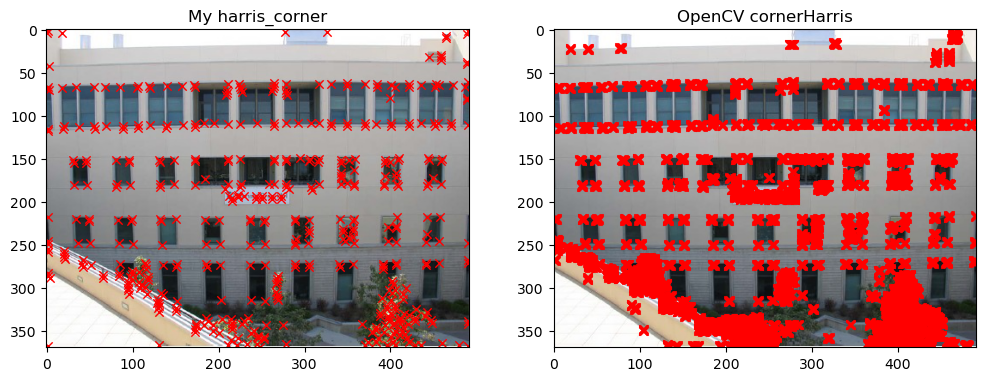

In [20]:
# Create a subplot with 1 row and 2 columns
fig, ax = plt.subplots(1, 2, figsize=(12, 10))

# Display the original image with detected Harris corners overlaid
ax[0].imshow(image_h1)
ax[0].scatter(index[:, 1], index[:, 0], marker="x", linewidths=1, c='r')  # Plot the Harris corners
ax[0].set_title("My harris_corner")

# Display the original image with detected corners using OpenCV's cornerHarris function overlaid
ax[1].imshow(image_h1)
ax[1].scatter(index_cv[:, 1], index_cv[:, 0], marker="x", linewidths=1, c='r')  # Plot the detected corners
ax[1].set_title("OpenCV cornerHarris")


plt.savefig('img/Harris1Corner.png')
# Show the plot
plt.show()


In [21]:
# Detect Harris corners in the loaded image with threshold value 0.01
harris_2 = harris_corner(image_h2, t=0.01)
index = np.argwhere(harris_2 > 0)  # Find the indices of Harris corners in harris_4

# Apply the Harris corner detection algorithm
dst = cv2.cornerHarris(image_h2, 2, 3, 0.04)
# Dilate the result for better visualisation of corners
dst = cv2.dilate(dst, None)
# Find the indices of corners detected by OpenCV's cornerHarris function
index_cv = np.argwhere(dst > 0.01 * dst.max())

Preprocess done.
Harris moments done
Non-Maximal Suppression done.


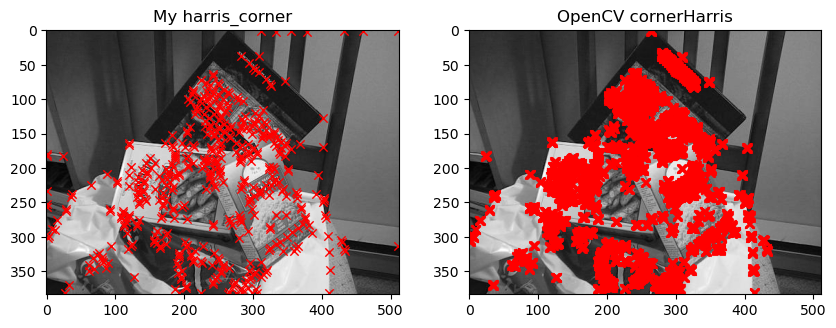

In [22]:
# Create a subplot with 1 row and 2 columns
fig, ax = plt.subplots(1, 2, figsize=(10, 10))

# Display the original image with detected Harris corners overlaid
ax[0].imshow(image_h2, cmap="gray")

ax[0].scatter(index[:, 1], index[:, 0], marker="x", linewidths=1, c='r')  # Plot the Harris corners
ax[0].set_title("My harris_corner")

# Display the original image with detected corners using OpenCV's cornerHarris function overlaid
ax[1].imshow(image_h2, cmap="gray")
ax[1].scatter(index_cv[:, 1], index_cv[:, 0], marker="x", linewidths=1, c='r')  # Plot the detected corners
ax[1].set_title("OpenCV cornerHarris")


plt.savefig('img/Harris2Corner.png')
# Show the plot
plt.show()


In [23]:
# Convert the image to grayscale using cv2.cvtColor()
harris_3 = cv2.cvtColor(image_h3, cv2.COLOR_BGR2GRAY)
# Detect Harris corners in the grayscale image with threshold value 0.01
harris_3 = harris_corner(harris_3, t=0.01)
# Find the indices of Harris corners in harris_4
index = np.argwhere(harris_3 > 0)  

## OpenCV Code
# Convert the image to grayscale
gray = cv2.cvtColor(image_h3, cv2.COLOR_BGR2GRAY)
# Convert the grayscale image to floating point format
gray = np.float32(gray)
# Apply the Harris corner detection algorithm
dst = cv2.cornerHarris(gray, 2, 3, 0.04)
# Dilate the result for better visualisation of corners
dst = cv2.dilate(dst, None)
# Find the indices of corners detected by OpenCV's cornerHarris function
index_cv = np.argwhere(dst > 0.01 * dst.max())

Preprocess done.
Harris moments done
Non-Maximal Suppression done.


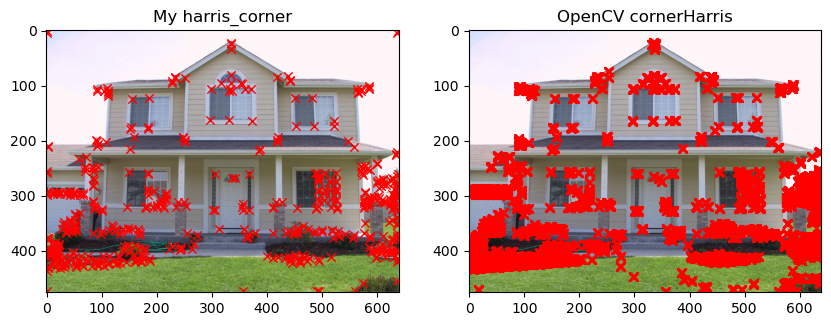

In [24]:
# Create a subplot with 1 row and 2 columns
fig, ax = plt.subplots(1, 2, figsize=(10, 10))

# Display the original image with detected Harris corners overlaid
ax[0].imshow(image_h3)

ax[0].scatter(index[:, 1], index[:, 0], marker="x", linewidths=1, c='r')  # Plot the Harris corners
ax[0].set_title("My harris_corner")

# Display the original image with detected corners using OpenCV's cornerHarris function overlaid
ax[1].imshow(image_h3)
ax[1].scatter(index_cv[:, 1], index_cv[:, 0], marker="x", linewidths=1, c='r')  # Plot the detected corners
ax[1].set_title("OpenCV cornerHarris")



plt.savefig('img/Harris3Corner.png')
# Show the plot
plt.show()


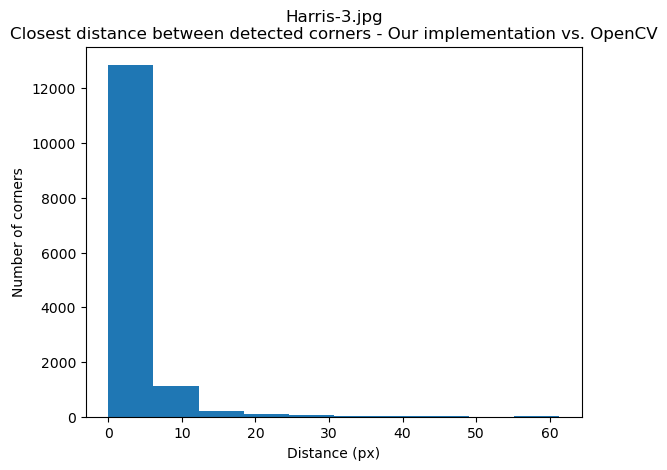

In [25]:
corner_dist = cdist(index, index_cv, metric='euclidean')
min_dist = np.min(corner_dist, axis=0)

plt.hist(min_dist)
plt.title("Harris-3.jpg\nClosest distance between detected corners - Our implementation vs. OpenCV")
plt.xlabel("Distance (px)")
plt.ylabel("Number of corners")
plt.show()

In [26]:
# Convert the image to grayscale using cv2.cvtColor()
harris_4 = cv2.cvtColor(image_h4, cv2.COLOR_BGR2GRAY)
# Detect Harris corners in the grayscale image with threshold value 0.01
harris_4 = harris_corner(harris_4, t=0.01)
# Find the indices of Harris corners in harris_4
index = np.argwhere(harris_4 > 0)  

## OpenCV Code
# Convert the image to grayscale
gray = cv2.cvtColor(image_h4, cv2.COLOR_BGR2GRAY)
# Convert the grayscale image to floating point format
gray = np.float32(gray)
# Apply the Harris corner detection algorithm
dst = cv2.cornerHarris(gray, 2, 3, 0.04)
# Dilate the result for better visualisation of corners
dst = cv2.dilate(dst, None)
# Find the indices of corners detected by OpenCV's cornerHarris function
index_cv = np.argwhere(dst > 0.01 * dst.max())

Preprocess done.
Harris moments done
Non-Maximal Suppression done.


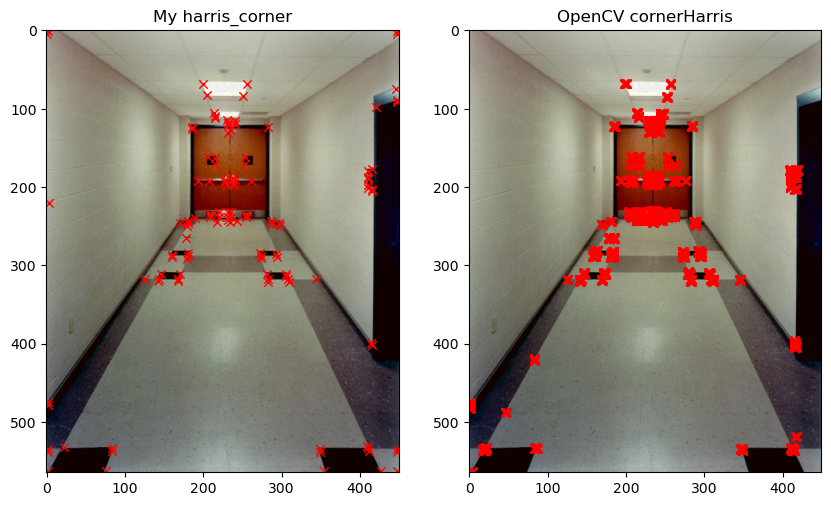

In [27]:
# Create a subplot with 1 row and 2 columns
fig, ax = plt.subplots(1, 2, figsize=(10, 10))

# Display the original image with detected Harris corners overlaid
ax[0].imshow(image_h4)

ax[0].scatter(index[:, 1], index[:, 0], marker="x", linewidths=1, c='r')  # Plot the Harris corners
ax[0].set_title("My harris_corner")

# Display the original image with detected corners using OpenCV's cornerHarris function overlaid
ax[1].imshow(image_h4)
ax[1].scatter(index_cv[:, 1], index_cv[:, 0], marker="x", linewidths=1, c='r')  # Plot the detected corners
ax[1].set_title("OpenCV cornerHarris")

plt.savefig('img/Harris4Corner.png')
# Show the plot
plt.show()


In [28]:
def inverse_warp(image, inv_matrix, output_shape):
    # Get the dimensions of the input image.
    if len(image.shape) == 2:
        y_shape, x_shape = image.shape
    elif len(image.shape) == 3:
        y_shape, x_shape, channels = image.shape

    # Create a new image with the specified output shape.
    new_image = np.zeros(output_shape)

    # Generate arrays representing the pixel coordinates of the input image.
    x = np.linspace(0, x_shape-1, x_shape).astype(int)
    y = np.linspace(0, y_shape-1, y_shape).astype(int)

    # Generate arrays representing the pixel coordinates of the output image.
    u = np.linspace(0, output_shape[1]-1, output_shape[1]).astype(int)
    v = np.linspace(0, output_shape[0]-1, output_shape[0]).astype(int)
    U, V = np.meshgrid(u, v)

    # Create an interpolation function for the input image.
    interp = RegularGridInterpolator((y, x), image, bounds_error=False)

    # Apply the inverted transformation matrix to the UV-grid.
    if len(inv_matrix) == 2:
        res_x, res_y = np.einsum("ji, mni -> jmn", inv_matrix, np.dstack([U, V, np.ones(U.shape)]))
    if len(inv_matrix) == 3:
        res_x, res_y, _ = np.einsum("ji, mni -> jmn", inv_matrix, np.dstack([U, V, np.ones(U.shape)]))

    # Use the interpolation function to obtain new image colors.
    new_image = interp((res_y, res_x))
    
    # Set out-of-bounds interpolations to 0.
    new_image[np.isnan(new_image)] = 0

    return new_image.astype(image.dtype)

In [29]:
# Obtains a rotation matrix for homogenised 2D-vectors.
# theta: Angle in terms of degrees, anti-clockwise.
def get_rotation_matrix(theta, center=(0, 0)):
    theta = np.radians(theta)
    s = np.sin(theta)
    
    c = np.cos(theta)

    x_dis, y_dis = center

    rot_mat = np.matrix([[c, s, (1-c)*x_dis-s*y_dis],
                         [-s, c, s*x_dis+(1-c)*y_dis]])
    
    return rot_mat

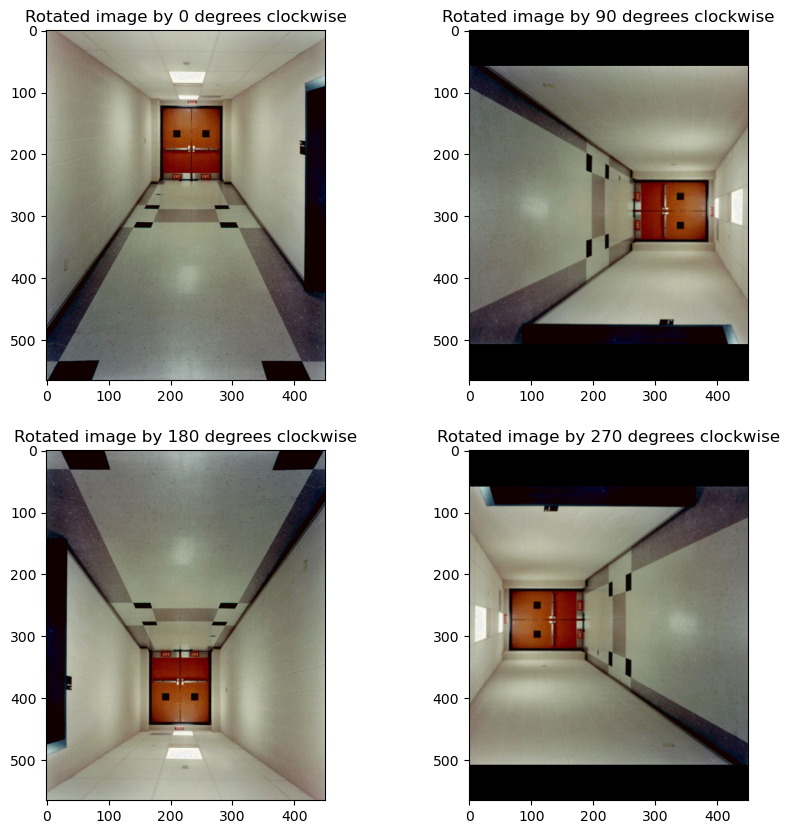

In [30]:
# Convert the image 'Harris-4.jpg' to grayscale.
bw = cv2.cvtColor(image_h4, cv2.COLOR_BGR2GRAY)

# Create a subplot with 2 rows and 2 columns.
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# Get the height and width of the image. 
if len(image_h4.shape) == 2:
    h, w = image_h4.shape
if len(image_h4.shape) == 3:
    h, w, c = image_h4.shape

# Calculate the center point of the image.
center = (w/2, h/2)

# Initialize a list to store the rotated images.
rotated_images = []

# Iterate over four clockwise rotation angles (0, 90, 180, 270 degrees).
for i in range(4):
    # Generate a rotation matrix for the current angle.
    rot_mat = get_rotation_matrix(90*i, center=center)
    # Apply inverse warping to rotate the image using the rotation matrix.
    rotated_aspect = (h, w)
    new_img = inverse_warp(image_h4, rot_mat, rotated_aspect)
    

    # Display the rotated image in the subplot corresponding to its rotation angle.
    ax[i//2, i%2].imshow(new_img, cmap="gray")
    ax[i//2, i%2].set_title(f'Rotated image by {90*i} degrees clockwise')

    # Add the rotated image to the list of rotated images.
    rotated_images.append(new_img)

plt.savefig('img/Harris4Rotated.png')
# Show the plot with the rotated images.
plt.show()


In [31]:
# Initialize an empty list to store the Harris corner responses of rotated images
rot_harris = []
# Iterate over the rotated images
for i in range(4):
    img_float32 = np.float32(rotated_images[i])
    bw = cv2.cvtColor(img_float32, cv2.COLOR_BGR2GRAY)
    # Detect Harris corners in each rotated image and append the result to the list
    rot_harris.append(harris_corner(bw))

Preprocess done.
Harris moments done
Non-Maximal Suppression done.
Preprocess done.
Harris moments done
Non-Maximal Suppression done.
Preprocess done.
Harris moments done
Non-Maximal Suppression done.
Preprocess done.
Harris moments done
Non-Maximal Suppression done.


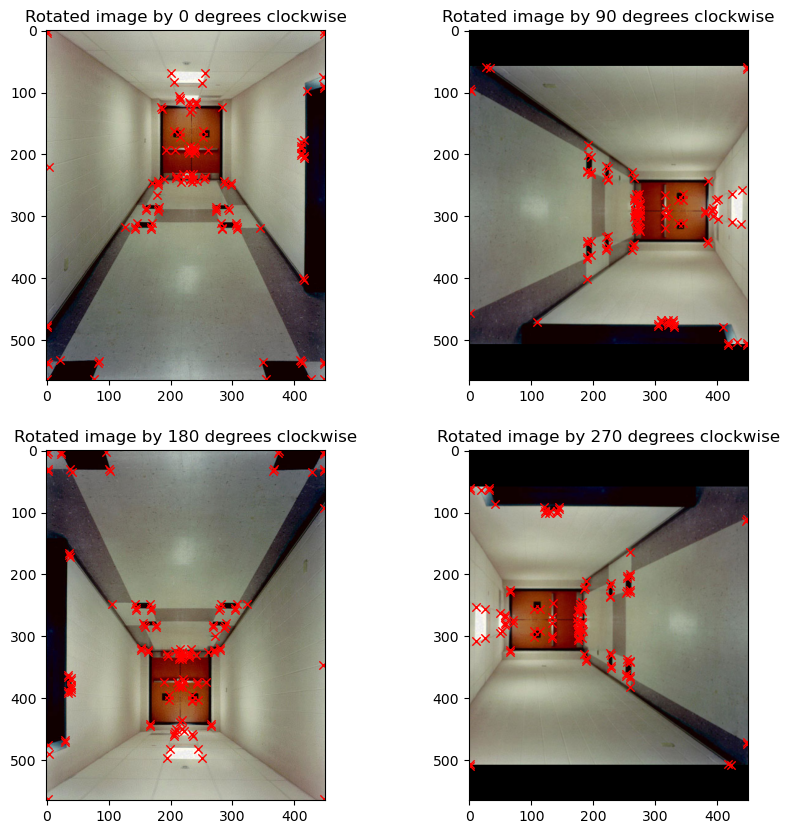

In [32]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

for idx in range(4):
    rot_img = rotated_images[idx]
    rot_h = rot_harris[idx]

    # Set the aspect ratio of the plot to be equal
    ax[idx//2, idx%2].set_aspect('equal')
    # Display the grayscale image 'new_img' with colormap 'gray'
    ax[idx//2, idx%2].imshow(rot_img, cmap="gray")
    # Find the indices of non-zero elements from the harris detection.
    index = np.argwhere(rot_h > 0)
    # Plot the non-zero elements as red 'x' markers
    ax[idx//2, idx%2].scatter(index[:, 1], index[:, 0], marker="x", linewidths=1, c='r')
    ax[idx//2, idx%2].set_title(f'Rotated image by {90*idx} degrees clockwise')

plt.savefig('img/Harris4RotatedCorner.png')
# Show the plot
plt.show()

(118, 2) (118, 2)
(392, 2) (108, 2)
(170, 2) (126, 2)
(392, 2) (103, 2)


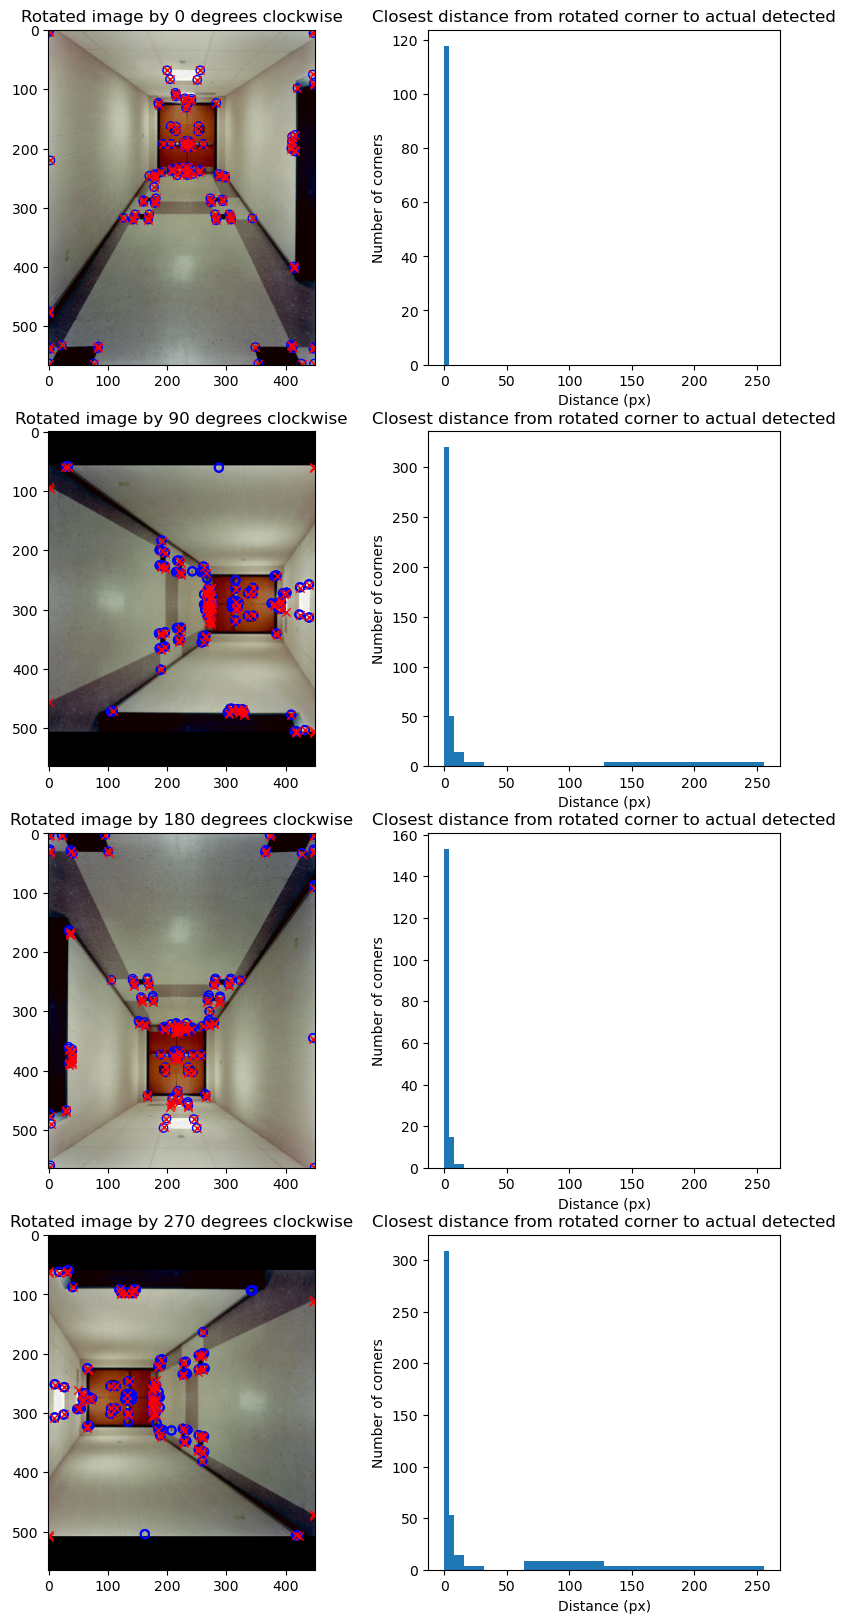

In [41]:
fig, ax = plt.subplots(4, 2, figsize=(10, 20))

# Get the height and width of the image. 
if len(image_h4.shape) == 2:
    h, w = image_h4.shape
if len(image_h4.shape) == 3:
    h, w, c = image_h4.shape

# Calculate the center point of the image.
center = (w/2, h/2)

# Iterate over four clockwise rotation angles (0, 90, 180, 270 degrees).
for i in range(4):
    # Generate a rotation matrix for the current angle.
    rot_mat = get_rotation_matrix(90*i, center=center)
    rotated_aspect = (h, w)

    # Apply rotation inverse warp on the Harris detections on the untransformed image.
    rot_meow = np.float32(rot_harris[0])
    rot_index = inverse_warp(rot_meow, rot_mat, rotated_aspect)
    rot_index = np.argwhere(rot_index > 0)

    # Find the indices of non-zero elements from the harris detection.
    rot_h = rot_harris[i]
    rot_h_index = np.argwhere(rot_h > 0)

    corner_dist = cdist(rot_h_index, rot_index, metric='euclidean')
    min_dist = np.min(corner_dist, axis=0)

    print(rot_index.shape, rot_h_index.shape)

    ax[i, 1].hist(min_dist, bins=[0, 4, 8, 16, 32, 64, 128, 256])
    ax[i, 1].set_title("Closest distance from rotated corner to actual detected")
    ax[i, 1].set_xlabel("Distance (px)")
    ax[i, 1].set_ylabel("Number of corners")
    
    # Display the rotated image in the subplot corresponding to its rotation angle.
    ax[i, 0].imshow(rotated_images[i], cmap="gray")
    ax[i, 0].scatter(rot_index[:, 1], rot_index[:, 0], facecolors='none', edgecolors='b')
    ax[i, 0].set_title(f'Rotated image by {90*i} degrees clockwise')

    # Display the rotated image in the subplot corresponding to its rotation angle.
    ax[i, 0].scatter(rot_h_index[:, 1], rot_h_index[:, 0], marker="x", linewidths=1, c='r')

plt.savefig('img/Harris4CornerHist.png')
plt.show()

In [34]:
# Detect Harris corners in the loaded image with threshold value 0.01
harris_5 = harris_corner(image_h5, t=0.01)
# Find indices of Harris corners detected by my implementation
index_my_impl = np.argwhere(harris_5 > 0)

# Detect Harris corners using OpenCV
dst = cv2.cornerHarris(image_h5, 2, 3, 0.04)
# Enlarge the areas with high Harris corner response to make them more visible
dst = cv2.dilate(dst, None)
# Find indices of Harris corners detected by OpenCV
index_opencv = np.argwhere(dst > 0.01 * dst.max())

Preprocess done.
Harris moments done
Non-Maximal Suppression done.


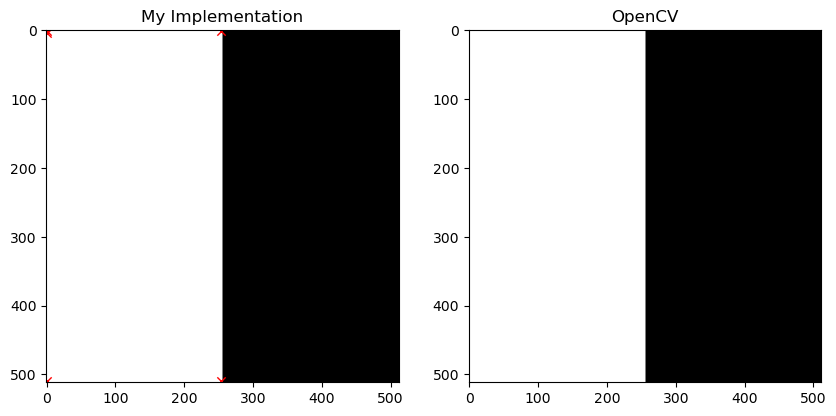

In [35]:
# Create subplots for displaying both OpenCV and my implementation
fig, ax = plt.subplots(1, 2, figsize=(10, 10))

# Set equal aspect ratio for both subplots
for a in ax:
    a.set_aspect('equal')

# Display the original image with Harris corners detected by my implementation
ax[0].imshow(image_h5, cmap="gray")
# Plot Harris corners detected by my implementation
ax[0].scatter(index_my_impl[:, 1], index_my_impl[:, 0], marker="x", linewidths=1, c='r')
ax[0].set_title('My Implementation')

# Display the original image with Harris corners detected by OpenCV
ax[1].imshow(image_h5, cmap="gray")
# Plot Harris corners detected by OpenCV
ax[1].scatter(index_opencv[:, 1], index_opencv[:, 0], marker="x", linewidths=1)
ax[1].set_title('OpenCV')

plt.savefig('img/Harris5Corner.png')
plt.show()

In [36]:
# Detect Harris corners in the loaded image with threshold value 0.01
harris_6 = harris_corner(image_h6, t=0.01)
# Find indices of Harris corners detected by my implementation
index_my_impl = np.argwhere(harris_6 > 0)

# Detect Harris corners using OpenCV
dst = cv2.cornerHarris(image_h6, 2, 3, 0.04)
# Enlarge the areas with high Harris corner response to make them more visible
dst = cv2.dilate(dst, None)
# Find indices of Harris corners detected by OpenCV
index_opencv = np.argwhere(dst > 0.01 * dst.max())

Preprocess done.
Harris moments done
Non-Maximal Suppression done.


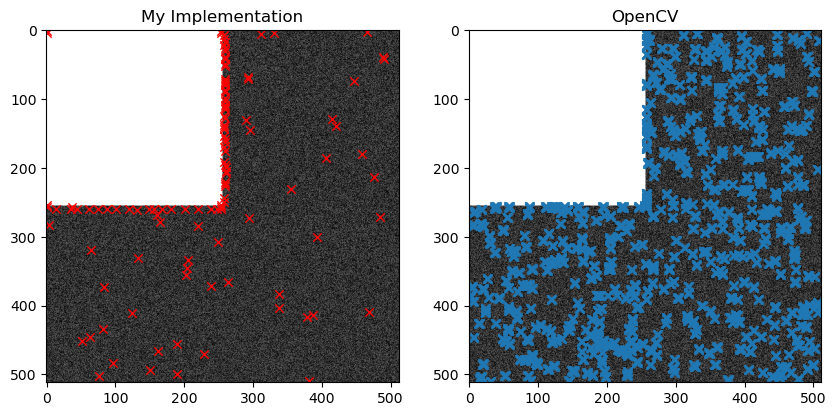

In [37]:
# Create subplots for displaying both OpenCV and my implementation
fig, ax = plt.subplots(1, 2, figsize=(10, 10))

# Set equal aspect ratio for both subplots
for a in ax:
    a.set_aspect('equal')

# Display the original image with Harris corners detected by my implementation
ax[0].imshow(image_h6, cmap="gray")

# Plot Harris corners detected by my implementation
ax[0].scatter(index_my_impl[:, 1], index_my_impl[:, 0], marker="x", linewidths=1, c='r')
ax[0].set_title('My Implementation')

# Display the original image with Harris corners detected by OpenCV
ax[1].imshow(image_h6, cmap="gray")
# Plot Harris corners detected by OpenCV
ax[1].scatter(index_opencv[:, 1], index_opencv[:, 0], marker="x", linewidths=1)
ax[1].set_title('OpenCV')

plt.savefig('img/Harris6Corner.png')
plt.show()

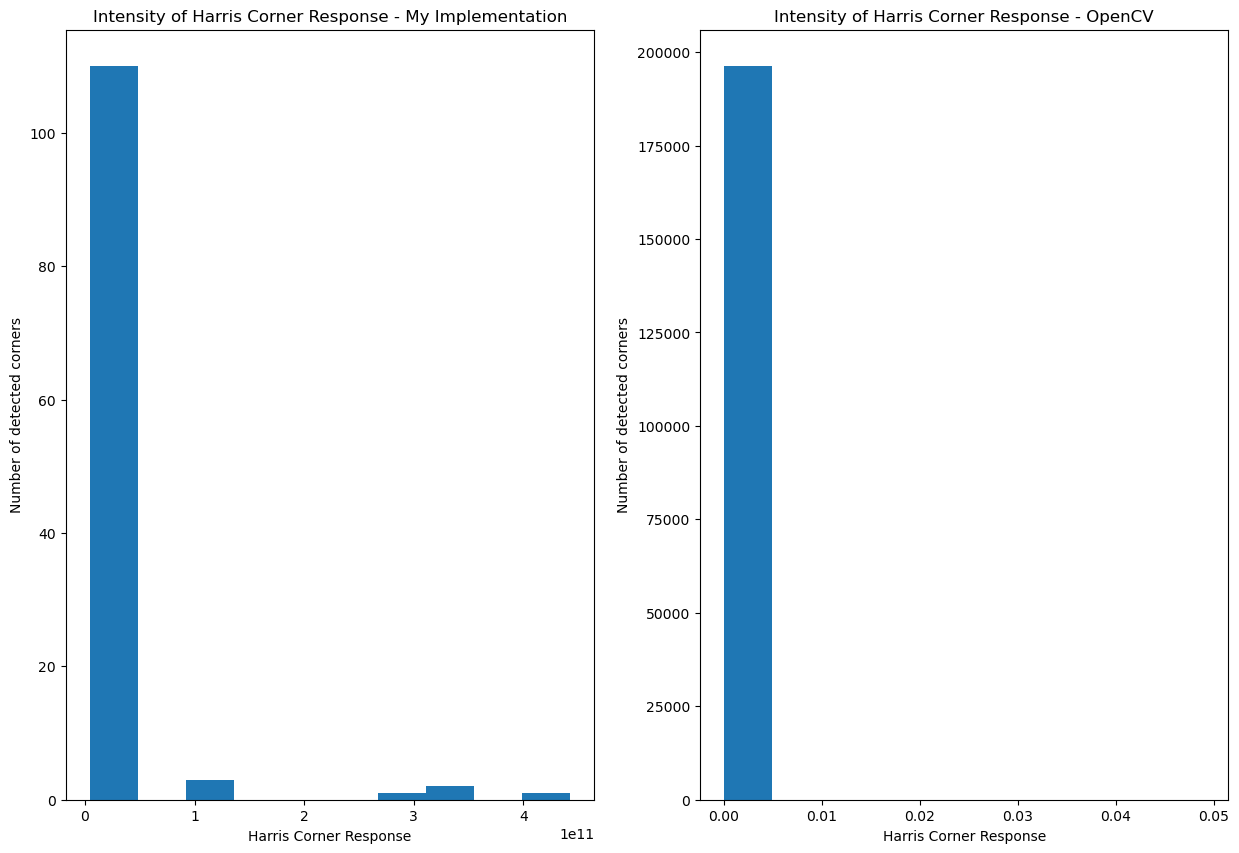

In [38]:
# Create subplots for displaying both OpenCV and my implementation
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].set_title('Intensity of Harris Corner Response - My Implementation')
ax[1].set_title('Intensity of Harris Corner Response - OpenCV')

ax[0].hist(harris_6[harris_6 > 0].flatten())
ax[1].hist(dst[dst > 0].flatten())

ax[0].set_ylabel("Number of detected corners")
ax[0].set_xlabel("Harris Corner Response")

ax[1].set_ylabel("Number of detected corners")
ax[1].set_xlabel("Harris Corner Response")
plt.savefig('img/Harris6hist.png')
plt.show()